In [ ]:
import pandas as pd
import math
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.mlab as mlab
import string


WIG_20 = np.array(["ACP","CDR","JSW","LTS","PEO","PKN","SPL","ALE","CPS","KGH","MRC","PGE","PKO","TPE","CCC","DNP","LPP","OPL","PGN","PZU"])

# # Ładujemy dane historyczne.
# wig_20_daily_url = 'https://raw.githubusercontent.com/wfica/inz_fin_1/main/wig20_d.csv'
# wig_20_daily_all = pd.read_csv(wig_20_daily_url)
# wig_20_daily_all['Date'] = pd.to_datetime(wig_20_daily_all['Date'])

# # Liczymy historyczne zwroty względne.
# wig_20_daily_all['Returns'] = wig_20_daily_all['Close'].pct_change()

# # Dane, które używamy do predykcji (td = training data).
# start_date = pd.to_datetime('2016-01-01')
# end_date = pd.to_datetime('2017-01-01')
# wig_20_daily_td = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= start_date) & (wig_20_daily_all['Date'] < end_date)]

# # Dni handlowe 
# trading_days = wig_20_daily_td.shape[0]
# dt = 1./ trading_days

# # Średnia i odchylenie standardowe
# mean = wig_20_daily_td['Returns'].mean()
# std = wig_20_daily_td['Returns'].std()

# # Normujemy parametry
# mu = mean * trading_days
# sigma = std * math.sqrt(trading_days)
# print(std)
# mu, sigma

0.01197013659990396


(0.06458126168654821, 0.18964262897700623)

In [ ]:
def ReadWig20DailyPrices(url_prefix = 'https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/notowania_wig_20/'):
  df = pd.DataFrame()
  for company in WIG_20:
    url = url_prefix + company[:3].lower() + '_d.csv'
    data = pd.read_csv(url)
    data['Data'] = pd.to_datetime(data['Data'])
    data['Zwroty_dzienne'] = data['Zamkniecie'].pct_change()
    data['Company'] = company
    df = df.append(data, ignore_index=True)
  return df


wig_20_all = ReadWig20DailyPrices()

In [ ]:
wig_20_all

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zwroty_dzienne,Company
0,2015-06-02,43.613,43.750,43.361,43.361,301234.0,NaN,ACP
1,2015-06-03,43.470,44.190,43.002,43.002,379703.0,-0.008279,ACP
2,2015-06-05,42.315,42.698,41.098,41.133,161965.0,-0.043463,ACP
3,2015-06-08,41.494,42.423,41.278,42.207,237014.0,0.026110,ACP
4,2015-06-09,42.207,42.885,41.485,42.244,136809.0,0.000877,ACP
...,...,...,...,...,...,...,...,...
77940,2021-10-07,37.870,38.480,37.560,38.480,4810808.0,0.023132,PZU
77941,2021-10-08,38.450,39.280,38.350,39.000,3324561.0,0.013514,PZU
77942,2021-10-11,39.000,39.750,38.880,39.700,3031319.0,0.017949,PZU
77943,2021-10-12,39.500,40.120,39.240,40.050,5198418.0,0.008816,PZU


In [ ]:
def ComputeModelParams(df=wig_20_all, start_date=pd.to_datetime('2015-03-01'), end_date= pd.to_datetime('2017-03-01'), tickers = WIG_20):
  stats = pd.DataFrame(columns=['Company', 'mean', 'std'])
  for i, ticker in enumerate(tickers):
    data = df[(df['Company'] == ticker) & (df['Data'] >= start_date) & (df['Data'] < end_date)]

    # Średnia i odchylenie standardowe
    mean = data['Zwroty_dzienne'].mean()
    std =  data['Zwroty_dzienne'].std()

    # Normujemy parametry
    trading_days = data.shape[0]
    mu = mean * trading_days
    sigma = std * math.sqrt(trading_days)
    
    stats.loc[i] = [ticker, mu, sigma]
  return stats

params = ComputeModelParams()

In [ ]:
params

,Company,mean,std
0,ACP,0.031949,0.309277
1,CDR,1.526713,0.536786
2,JSW,1.554177,0.909995
3,LTS,0.703614,0.397439
4,PEO,-0.094685,0.375049
5,PKN,0.685696,0.412444
6,SPL,0.207386,0.475785
7,ALE,NaN,NaN
8,CPS,0.046705,0.413685
9,KGH,0.282483,0.575220


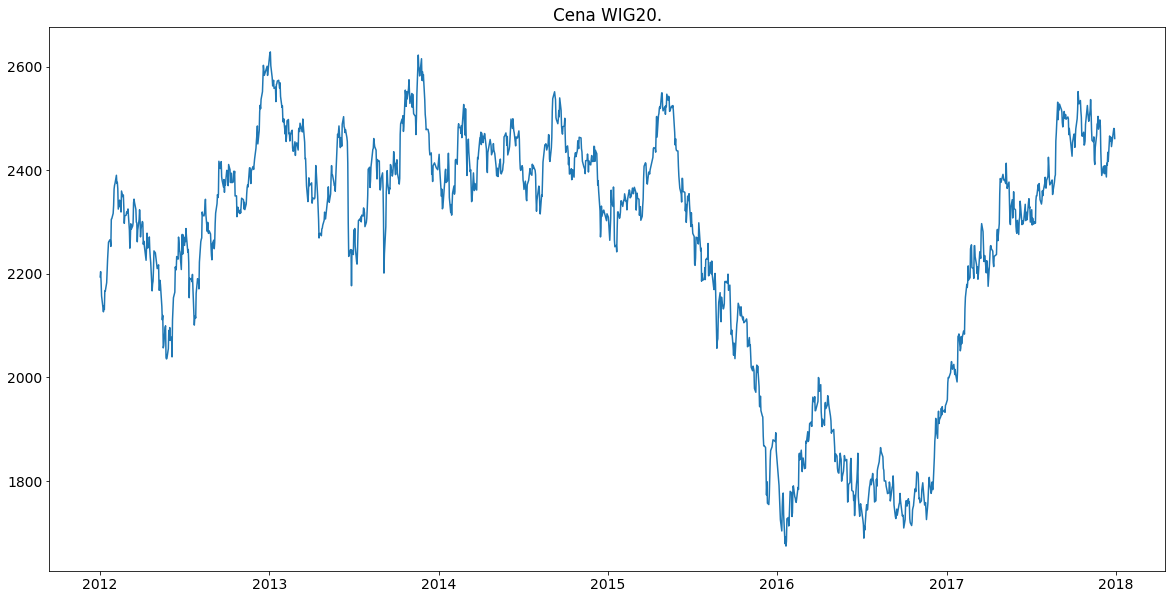

In [ ]:
plot_start = pd.to_datetime('2012-01-01')
plot_end = pd.to_datetime('2017-12-31')
wig_20_plot = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= plot_start) & (wig_20_daily_all['Date'] < plot_end)]

plt.figure(figsize=(20,10))
plt.plot(wig_20_plot['Date'],wig_20_plot['Close']  )
plt.title('Cena WIG20.')
plt.show()
# plt.savefig('wig20_cena.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('wig20_cena.png')

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  2.,  5.,  4.,  1.,  6.,  5., 16.,
        13., 21., 27., 21., 35., 22., 16., 15., 14.,  7.,  5.,  3.,  4.,
         2.,  2.,  0.,  2.]),
 array([-0.04533611, -0.04262867, -0.03992123, -0.03721379, -0.03450635,
        -0.03179892, -0.02909148, -0.02638404, -0.0236766 , -0.02096916,
        -0.01826172, -0.01555428, -0.01284684, -0.0101394 , -0.00743196,
        -0.00472453, -0.00201709,  0.00069035,  0.00339779,  0.00610523,
         0.00881267,  0.01152011,  0.01422755,  0.01693499,  0.01964242,
         0.02234986,  0.0250573 ,  0.02776474,  0.03047218,  0.03317962,
         0.03588706]),
 <a list of 30 Patch objects>)

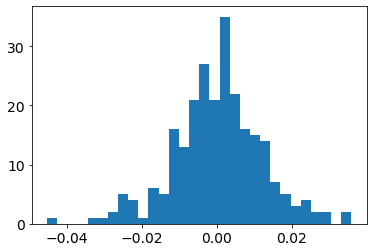

In [ ]:
plt.hist(wig_20_daily_td['Returns'].values.flatten(), bins=30)
# wig_20_daily_td['Returns'].values.flatten().shape